In [1]:
import copy
import os
from os.path import join as oj
import glob
import argparse
import pickle as pkl
import time
import warnings
from scipy import stats
import dask
from dask.distributed import Client
import numpy as np
from tqdm import tqdm
import sys
from collections import defaultdict
from typing import Callable, List, Tuple
import itertools
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, mean_squared_error
import sys
sys.path.append(".")
sys.path.append("..")
sys.path.append("../../imodels/")

warnings.filterwarnings("ignore", message="Bins whose width")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_absolute_error, accuracy_score, roc_auc_score, mean_squared_error

from imodels.importance import RandomForestPlusRegressor, RandomForestPlusClassifier, \
    RidgeRegressorPPM, LassoRegressorPPM, IdentityTransformer
from imodels.importance.rf_plus import _fast_r2_score
import seaborn as sns
from util import ModelConfig, FIModelConfig, tp, fp, neg, pos, specificity_score, auroc_score, auprc_score, compute_nsg_feat_corr_w_sig_subspace, apply_splitting_strategy
from scripts.competing_methods_local import *
from scripts.simulations_util import *

In [2]:
def generate_random_shuffle(data, seed):
    """
    Randomly shuffle each column of the data.
    """
    np.random.seed(seed)
    return np.array([np.random.permutation(data[:, i]) for i in range(data.shape[1])]).T


def ablation(data, feature_importance, mode, num_features, seed):
    """
    Replace the top num_features max feature importance data with random shuffle for each sample
    """
    assert mode in ["max", "min"]
    fi = feature_importance.to_numpy()
    shuffle = generate_random_shuffle(data.copy(), seed)
    if mode == "max":
        indices = np.argsort(-fi)
    else:
        indices = np.argsort(fi)
    data_copy = data.copy()
    for i in range(data.shape[0]):
        for j in range(num_features):
            data_copy[i, indices[i,j]] = shuffle[i, indices[i,j]]
    return data_copy


#### Demo of Getting LFI on synthetic dataset

In [3]:
seed = 0
n = 200
d = 10
mean = [[0]*5 + [0]*5, [10]*5 + [0]*5]
scale = [[1]*10,[1]*10]
s = 5
X = sample_normal_X_subgroups(n, d, mean, scale)
beta = np.concatenate((np.ones(s), np.zeros(d-s)))
y = np.matmul(X, beta)
split_seed = 0
X_train, X_tune, X_test, y_train, y_tune, y_test = apply_splitting_strategy(X, y, "train-test", split_seed)

In [4]:
rf_regressor = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, max_features=0.33, random_state=331)
rf_plus_model = RandomForestPlusRegressor(rf_model=copy.deepcopy(rf_regressor), include_raw=False)
rf_plus_model.fit(X_train, y_train)
score = rf_plus_model.get_mdi_plus_scores(X_test, y_test, lfi=True, lfi_abs = "none", sample_split=None, train_or_test = "test")
score["lfi"]

,0,1,2,3,4,5,6,7,8,9
0,-5.088500,-5.434242,-4.991069,-3.523977,-6.970922,-0.100924,0.026376,0.035818,0.056386,0.051968
1,2.764917,4.137349,5.193189,5.391856,5.753658,0.255646,0.123146,-0.106489,-0.202590,-0.066455
2,3.106396,4.539266,5.490331,5.189864,5.173795,-0.065447,0.148627,0.122819,0.005830,-0.096353
3,-4.588541,-6.086855,-3.594542,-4.895289,-6.721405,-0.154559,0.041410,-0.027605,0.079789,0.061801
4,3.619092,4.383323,5.584341,5.471017,5.410562,-0.141847,0.128953,-0.083198,-0.041005,-0.073253
...,...,...,...,...,...,...,...,...,...,...
61,-1.766681,-7.603500,-8.220454,-5.161473,-2.796103,-0.030366,-0.038042,0.091785,0.098503,-0.046698
62,2.741698,5.385319,5.556246,5.029102,5.279129,-0.245193,-0.017137,-0.035064,0.064457,0.067401
63,-2.967082,-5.086932,-5.681010,-6.023576,-6.841122,-0.078081,-0.003156,-0.042409,0.079129,-0.039798
64,3.083046,4.579605,5.898840,5.549945,5.143313,-0.098881,-0.019955,0.055983,-0.110792,-0.057828


In [5]:
rf_regressor = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, max_features=0.33, random_state=331)
rf_plus_model = RandomForestPlusRegressor(rf_model=copy.deepcopy(rf_regressor), include_raw=True)
rf_plus_model.fit(X_train, y_train)
score = rf_plus_model.get_mdi_plus_scores(X_test, y_test, lfi=True, lfi_abs = "none", sample_split=None, train_or_test = "test")
score["lfi"]

,0,1,2,3,4,5,6,7,8,9
0,-4.807901,-7.209508,-5.632134,-4.316089,-6.514966,-0.022138,0.010484,0.000019,0.000945,0.049320
1,3.545588,5.432350,4.918241,5.265671,5.601412,0.106922,0.015000,-0.008629,-0.028517,-0.027213
2,2.370667,6.382873,5.921998,3.285803,5.444351,-0.008084,0.004845,-0.017110,-0.020245,-0.021540
3,-5.042271,-7.070407,-3.897698,-4.585583,-5.974616,-0.021916,0.014276,-0.006384,0.013726,0.038225
4,5.391207,6.068054,4.934130,5.354874,3.986508,-0.007785,0.016060,-0.011519,-0.018789,-0.028593
...,...,...,...,...,...,...,...,...,...,...
61,-3.361236,-6.595049,-6.962750,-4.903036,-4.350524,-0.004708,-0.004011,0.006908,0.010212,-0.011898
62,3.090214,5.484463,6.186467,3.609285,5.458421,-0.065593,-0.003169,0.000872,0.017937,0.048034
63,-4.345699,-7.305466,-6.149829,-6.354446,-5.676841,-0.028384,-0.009955,0.014977,0.007559,-0.003158
64,4.450948,5.618828,4.639036,5.584950,3.979936,-0.051567,0.001682,0.002815,-0.011503,-0.025642


#### Demo of Getting LFI on real dataset

In [6]:
X= sample_real_data(X_fpath="../data/regression_data/Diabetes_regression/X_diabetes_regression.csv", return_data="X")
y,_,_ = sample_real_data(y_fpath="../data/regression_data/Diabetes_regression/y_diabetes_regression.csv", return_data="y")
split_seed = 0
X_train, X_tune, X_test, y_train, y_tune, y_test = apply_splitting_strategy(X, y, "train-test", split_seed)

In [7]:
rf_regressor = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, max_features=0.33, random_state=331)
rf_plus_model = RandomForestPlusRegressor(rf_model=copy.deepcopy(rf_regressor), include_raw=False)
rf_plus_model.fit(X_train, y_train)
score = rf_plus_model.get_mdi_plus_scores(X_test, y_test, lfi=True, lfi_abs = "none", sample_split=None, train_or_test = "test")
score["lfi"]

,0,1,2,3,4,5,6,7,8,9
0,-0.550547,-0.509158,31.835900,19.139330,2.325505,1.162797,5.784248,4.355924,-3.435516,6.983539
1,-1.952644,0.476303,26.834794,11.085726,-1.184243,-0.707550,3.338092,5.283813,29.656309,-4.632624
2,1.091275,-0.807457,4.199084,12.741000,-1.864084,-1.303363,9.179254,5.221634,-18.564621,-3.281195
3,-2.094094,2.666919,-14.618491,-3.852838,-1.923632,0.006683,12.227833,5.104439,-26.855199,-6.084755
4,-0.849213,0.038342,22.476313,23.499741,0.391009,0.128469,-9.155953,-9.546809,-25.071031,0.576129
...,...,...,...,...,...,...,...,...,...,...
141,-0.986964,0.344177,26.229870,-9.791403,-1.525023,-3.503921,5.838443,5.554142,30.810890,8.959744
142,-0.953453,-2.655438,-8.247578,-6.799813,0.219373,0.359380,9.568290,8.402292,12.944425,-7.018445
143,0.530253,2.548234,10.269390,-5.271638,-2.198030,0.158011,10.954610,5.867279,-30.756847,-5.920799
144,-1.068572,2.101520,-20.770480,-4.498713,2.953514,2.725043,13.919418,8.782769,-17.015294,-0.390079


In [8]:
rf_regressor = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, max_features=0.33, random_state=331)
rf_plus_model = RandomForestPlusRegressor(rf_model=copy.deepcopy(rf_regressor), include_raw=True)
rf_plus_model.fit(X_train, y_train)
score = rf_plus_model.get_mdi_plus_scores(X_test, y_test, lfi=True, lfi_abs = "none", sample_split=None, train_or_test = "test")
score["lfi"]

,0,1,2,3,4,5,6,7,8,9
0,-0.568338,-3.140484,55.070319,20.861975,4.174052,1.987877,5.349877,1.826471,0.228862,4.128515
1,-1.166199,2.387537,34.800144,13.973098,-3.364454,-1.772468,3.191420,2.764682,36.252912,-2.385996
2,0.037728,-3.309672,3.956252,13.199977,1.033876,0.125522,7.877395,2.373263,-14.820934,-2.533580
3,-1.842783,4.113860,-16.057963,-7.005117,-0.718680,-0.476510,6.609966,2.281356,-25.403507,-2.660559
4,-0.223760,2.127213,24.417429,25.417788,1.598284,2.497530,-12.152124,-4.867344,-23.487523,0.559022
...,...,...,...,...,...,...,...,...,...,...
141,-0.691171,2.363649,44.208734,-9.326970,-6.187857,-7.232191,8.998206,4.096739,41.533338,5.923372
142,-0.878030,-4.712222,-3.719420,-3.638139,0.681294,-0.184722,9.330502,4.320302,12.125913,-2.776296
143,1.141859,3.984417,8.054122,-13.506195,1.534749,1.091389,7.621710,2.733325,-51.202669,-3.356039
144,-0.782307,3.778646,-30.535325,-9.139004,0.867085,-0.907354,9.244060,4.242567,-11.024220,-0.260673


#### Demo of Ablation

In [9]:
# Define the data
X= sample_real_data(X_fpath="../data/regression_data/Diabetes_regression/X_diabetes_regression.csv", return_data="X")
y,_,_ = sample_real_data(y_fpath="../data/regression_data/Diabetes_regression/y_diabetes_regression.csv", return_data="y")
split_seed = 0
X_train, X_tune, X_test, y_train, y_tune, y_test = apply_splitting_strategy(X, y, "train-test", split_seed)

#Define the model and fit
rf_regressor = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, max_features=0.33, random_state=331)
rf_regressor.fit(X_train, y_train)
seed = 0

In [ ]:
metric_results_LFI = {}
y_pred = rf_regressor.predict(X_test)
metric_results_LFI['MSE_before_ablation'] = mean_squared_error(y_test, y_pred)
local_fi_score = LFI_ablation_test_evaluation(X_train, y_train, X_test, y_test, rf_regressor, include_raw=False)
ascending = True
imp_vals = copy.deepcopy(local_fi_score)
imp_vals[imp_vals == float("-inf")] = -sys.maxsize - 1
imp_vals[imp_vals == float("inf")] = sys.maxsize - 1
for i in range(X_test.shape[1]):
    if ascending:
        ablation_X_test = ablation(X_test, imp_vals, "max", i+1, seed)
    else:
        ablation_X_test = ablation(X_test, imp_vals, "min", i+1, seed)
    metric_results_LFI[f'MSE_after_ablation_{i+1}'] = mean_squared_error(y_test, rf_regressor.predict(ablation_X_test))

In [10]:
metric_results_shap = {}
y_pred = rf_regressor.predict(X_test)
metric_results_shap['MSE_before_ablation'] = mean_squared_error(y_test, y_pred)
local_fi_score = tree_shap_local(X_test, y_test, rf_regressor)
ascending = True
imp_vals = copy.deepcopy(local_fi_score)
imp_vals[imp_vals == float("-inf")] = -sys.maxsize - 1
imp_vals[imp_vals == float("inf")] = sys.maxsize - 1
seed = np.random.randint(0, 100000)
for i in range(X_test.shape[1]):
    if ascending:
        ablation_X_test = ablation(X_test, imp_vals, "max", i+1, seed)
    else:
        ablation_X_test = ablation(X_test, imp_vals, "min", i+1, seed)
    metric_results_shap[f'MSE_after_ablation_{i+1}'] = mean_squared_error(y_test, rf_regressor.predict(ablation_X_test))

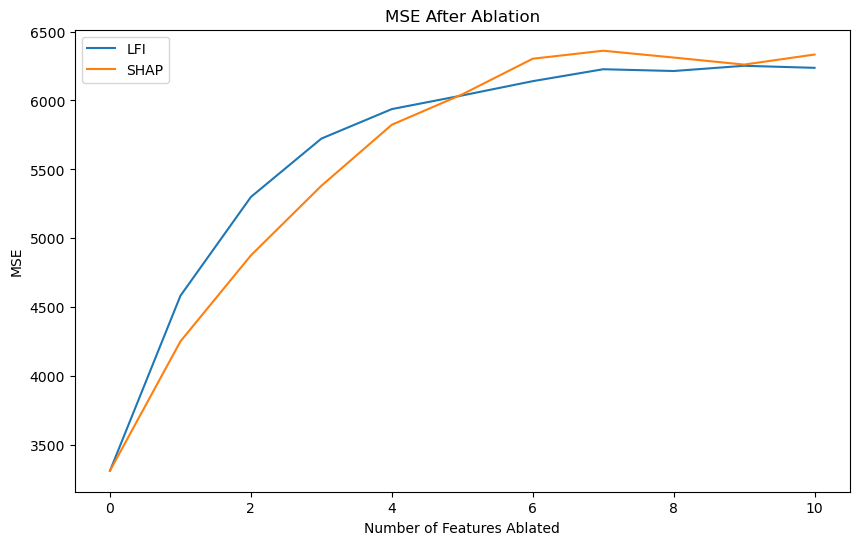

In [21]:
mse_LFI = [metric_results_LFI['MSE_before_ablation']] + [metric_results_LFI[f'MSE_after_ablation_{i+1}'] for i in range(X_test.shape[1])]
mse_SHAP =[metric_results_LFI['MSE_before_ablation']] + [metric_results_shap[f'MSE_after_ablation_{i+1}'] for i in range(X_test.shape[1])]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(len(mse_LFI)), mse_LFI, label='LFI')
plt.plot(range(len(mse_SHAP)), mse_SHAP, label='SHAP')
plt.xlabel('Number of Features Ablated')
plt.ylabel('MSE')
plt.title('MSE After Ablation')
plt.legend()
plt.show()